Logistic regression and KNN

In [143]:
# ========================================
# Install required libraries
# This installs Kaggle API (for Titanic dataset) and XGBoost (for gradient boosting model)
# ========================================
!pip install -q kaggle xgboost

# ========================================
# Import libraries
# ========================================
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

In [144]:
# Download the Titanic dataset from Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"shamsismayilova","key":"35a218798ed9ad4598d3b088f6758334"}'}

In [145]:
!kaggle competitions download -c titanic
!unzip -o titanic.zip

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [146]:
# === Load the data ===
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [147]:
# === Fill missing values ===
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# === Encode categorical variables ===
train = pd.get_dummies(train, columns=['Sex', 'Embarked'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex', 'Embarked'], drop_first=True)

# === Select features ===
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
           'Sex_male', 'Embarked_Q', 'Embarked_S']]
y = train['Survived']

# === Split into train/validation sets ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Scale data for KNN & Logistic Regression ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


/tmp/ipython-input-367668921.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/tmp/ipython-input-367668921.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [148]:
# === Train and evaluate Logistic Regression ===

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_val_scaled)
acc_lr = accuracy_score(y_val, y_pred_lr)

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")

Logistic Regression Accuracy: 0.8101


In [149]:
# === Train and evaluate KNN ===

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_val_scaled)
acc_knn = accuracy_score(y_val, y_pred_knn)

print(f"KNN Accuracy: {acc_knn:.4f}")

KNN Accuracy: 0.8045


In [150]:
# === Train and evaluate XGBoost ===

xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
acc_xgb = accuracy_score(y_val, y_pred_xgb)

print(f"XGBoost Accuracy: {acc_xgb:.4f}")


XGBoost Accuracy: 0.8212


In [151]:
# === Show results table ===

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'XGBoost'],
    'Accuracy': [acc_lr, acc_knn, acc_xgb]
})
print(results.sort_values(by='Accuracy', ascending=False))


                 Model  Accuracy
2              XGBoost  0.821229
0  Logistic Regression  0.810056
1                  KNN  0.804469


In [152]:
# === Reload original data ===
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# === Create new features ===
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

# === Extract titles from names ===
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

for df in [train, test]:
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                       'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

# === Fill missing values (safe way, no inplace warnings) ===
train['Age'] = train['Age'].fillna(train['Age'].median())
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

# === Encode categorical features ===
train = pd.get_dummies(train, columns=['Sex', 'Embarked', 'Title'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# === Align train/test columns ===
missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test[train.columns.drop('Survived')]

# === Select features ===
X = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone',
           'Sex_male', 'Embarked_Q', 'Embarked_S',
           'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']]
y = train['Survived']

# === Split and scale ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [153]:
# Scale only the selected features for models (KNN, Logistic Regression)
# This ensures all numeric features are standardized for better model performance
features = ['Pclass', 'Age', 'Fare', 'FamilySize', 'IsAlone',
            'Sex_male', 'Embarked_Q', 'Embarked_S',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']

X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled   = scaler.transform(X_val[features])


In [154]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 5, 10],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5)
grid_lr.fit(X_train_scaled, y_train)
print("Best LR params:", grid_lr.best_params_)
print("Best LR accuracy:", grid_lr.best_score_)


Best LR params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best LR accuracy: 0.8314389835516597


In [155]:
# KNN tuning
param_grid_knn = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan and Euclidean
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train_scaled, y_train)
print("Best KNN params:", grid_knn.best_params_)
print("Best KNN accuracy:", grid_knn.best_score_)

Best KNN params: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
Best KNN accuracy: 0.8342657342657341


In [156]:
# 5-fold CV to estimate Logistic Regression generalization

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)
print("CV accuracies:", cv_scores)
print("Mean CV accuracy (LogReg):", cv_scores.mean())


CV accuracies: [0.83916084 0.83916084 0.83098592 0.78169014 0.85211268]
Mean CV accuracy (LogReg): 0.8286220821432089


In [159]:
# === Refit best models and compare ===
best_lr = grid_lr.best_estimator_
best_knn = grid_knn.best_estimator_
xgb = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=4)
xgb.fit(X_train, y_train)

# Accuracy on validation set
acc_lr2  = accuracy_score(y_val, best_lr.predict(X_val_scaled))
acc_knn2 = accuracy_score(y_val, best_knn.predict(X_val_scaled))
acc_xgb2 = accuracy_score(y_val, xgb.predict(X_val))

# CV for Logistic Regression (already done)
cv_scores_lr = cross_val_score(best_lr, X_train_scaled, y_train, cv=5)

# CV for KNN
cv_scores_knn = cross_val_score(best_knn, X_train_scaled, y_train, cv=5)

# CV for XGBoost (no scaling needed)
cv_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)

# Combine into a DataFrame
results_improved = pd.DataFrame({
    'Model': ['Logistic Regression (tuned)', 'KNN (tuned)', 'XGBoost (improved)'],
    'CV Accuracy (mean)': [cv_scores_lr.mean(), cv_scores_knn.mean(), cv_scores_xgb.mean()],
    'Validation Accuracy': [acc_lr2, acc_knn2, acc_xgb2]
})

print("Improved Results:")
print(results_improved.sort_values(by='Validation Accuracy', ascending=False))

Improved Results:
                         Model  CV Accuracy (mean)  Validation Accuracy
2           XGBoost (improved)            0.830011             0.826816
0  Logistic Regression (tuned)            0.831439             0.810056
1                  KNN (tuned)            0.834266             0.798883


In [179]:
# === Upload new CSV ===
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)


Saving train_cleaned_filled.csv to train_cleaned_filled (3).csv


In [180]:
print(data.columns)


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [181]:
# === Create new features ===
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# === Extract titles ===
data['Title'] = data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                       'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

# === Fill missing values ===
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# === Encode categorical variables ===
data = pd.get_dummies(data, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# === Features ===
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone',
            'Sex_male', 'Embarked_Q', 'Embarked_S',
            'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']

X = data[features]
y = data['Survived']  # если есть целевой столбец

# === Split for training and validation ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Scale numeric features for Logistic Regression and KNN ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

# === Train models ===
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

xgb = XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=4)
xgb.fit(X_train, y_train)  # XGBoost не требует масштабирования

# === Predict and evaluate ===
y_pred_lr = log_reg.predict(X_val_scaled)
y_pred_knn = knn.predict(X_val_scaled)
y_pred_xgb = xgb.predict(X_val)

print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr)*100, "%")
print("KNN Accuracy:", accuracy_score(y_val, y_pred_knn)*100, "%")
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred_xgb)*100, "%")

Logistic Regression Accuracy: 82.12290502793296 %
KNN Accuracy: 79.3296089385475 %
XGBoost Accuracy: 83.79888268156425 %


In [182]:
# Extra check for accuracy results

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, solver='lbfgs')
log_model.fit(X_train_scaled, y_train)

print("Train accuracy:", log_model.score(X_train_scaled, y_train))
print("Validation accuracy:", log_model.score(X_val_scaled, y_val))


Train accuracy: 0.8356741573033708
Validation accuracy: 0.8212290502793296


In [183]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

print("Train accuracy:", knn_model.score(X_train_scaled, y_train))
print("Validation accuracy:", knn_model.score(X_val_scaled, y_val))


Train accuracy: 0.8637640449438202
Validation accuracy: 0.7932960893854749


In [184]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("Train accuracy:", xgb_model.score(X_train, y_train))
print("Validation accuracy:", xgb_model.score(X_val, y_val))


Train accuracy: 0.9662921348314607
Validation accuracy: 0.8379888268156425


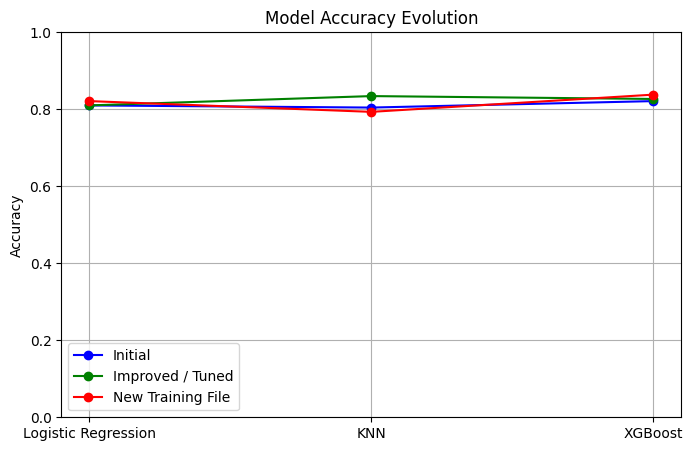

In [187]:
import matplotlib.pyplot as plt
import pandas as pd

# === Create a DataFrame with all results ===
# Columns: models and their accuracies for initial, improved, and new data
results_all = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'XGBoost'],
    'Initial': [0.810056, 0.804469, 0.821229],
    'Improved': [0.810056, 0.834266, 0.826816],
    'New Data': [0.821229, 0.793296, 0.837988]  # accuracy as a fraction (0-1)
})

# === Plot accuracy evolution for each model ===
fig, ax = plt.subplots(figsize=(8,5))

x = range(len(results_all['Model']))

# Plot each stage
ax.plot(x, results_all['Initial'], marker='o', label='Initial', color='blue')
ax.plot(x, results_all['Improved'], marker='o', label='Improved / Tuned', color='green')
ax.plot(x, results_all['New Data'], marker='o', label='New Training File', color='red')

# Set model names on X-axis
ax.set_xticks(x)
ax.set_xticklabels(results_all['Model'])

# Set Y-axis limits and label
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')

# Set title and legend
ax.set_title('Model Accuracy Evolution')
ax.legend()

# Add grid for better readability
ax.grid(True)

# Show the plot
plt.show()
